In [1]:
import Pkg
using PyPlot

In [2]:
# Install the package from GitHub (this only needs to be done once per julia installation)
#Pkg.add(url="https://github.com/herzfeldd/FlocculusClassifier2025.jl.git") 

In [3]:
# Load the package
import FlocculusClassifier2025

[ Info: Precompiling FlocculusClassifier2025 [7dbedddd-971f-49e9-a779-5306c8e57587] (cache misses: include_dependency fsize change (4))


# Download example recording

In [4]:
# Use an example recording from Open Science Framework (OSF)
# This recording from Monkey Yoda is 1 channel encoded as a 16 bit signed integers at 40 kHz.
# We will load it directly from the OSF website
wideband_recording = FlocculusClassifier2025.FlatRecording("https://osf.io/download/8k59f/", 1, 40000.0)

Recording @ 40000.0 Hz. 1 channel(s) x 56724873 timepoints


The original recording is wideband data (without significant filtering).
To use the classifier, we need to filter the data into the LFP and spike bands.

# Preprocess voltage/recording

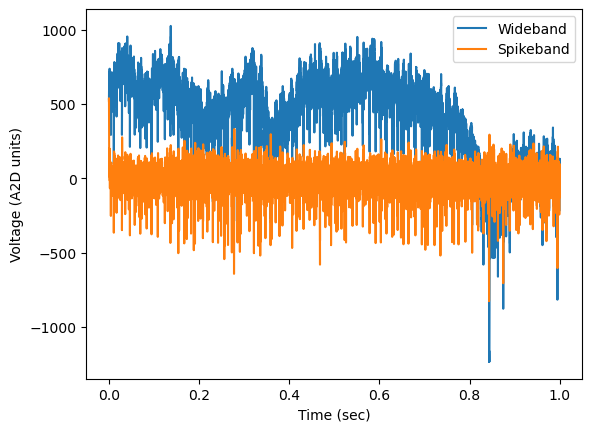

In [5]:
# Preprocess the wideband data into the "spike band"
recording_spike_band = FlocculusClassifier2025.preprocess_spikeband(wideband_recording)

t = range(0, 1, length=40000)
plot(t, wideband_recording[1:40000], label="Wideband")
plot(t, recording_spike_band[1, 1:40000], label="Spikeband")
legend();
xlabel("Time (sec)")
ylabel("Voltage (A2D units)");

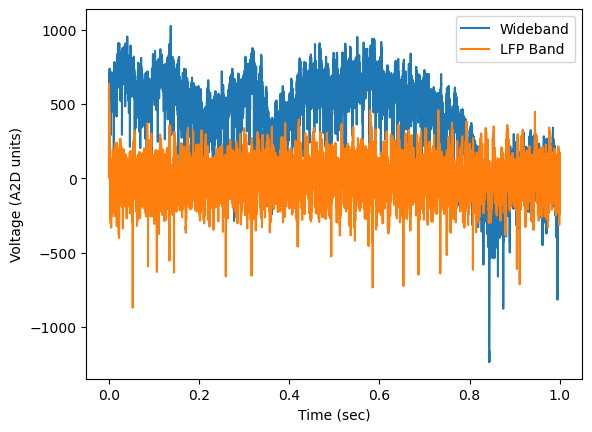

In [6]:
# Preprocess the wideband data into the LFP band
recording_lfp_band = FlocculusClassifier2025.preprocess_lfpband(wideband_recording)

t = range(0, 1, length=40000)
plot(t, wideband_recording[1:40000], label="Wideband")
plot(t, recording_lfp_band[1, 1:40000], label="LFP Band")
legend()
xlabel("Time (sec)")
ylabel("Voltage (A2D units)");

# Download example units

In [7]:
neuron = FlocculusClassifier2025.Neuron("https://osf.io/download/g6hq3/")

Neuron with 1473 spikes @ 40000 Hz.

# Extract waveform features

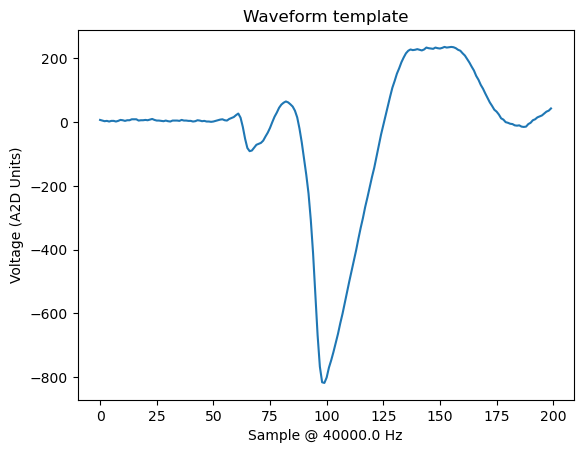

PyObject Text(0.5, 1.0, 'Waveform template')

In [8]:
# Plot the primary channel waveform using a simplified approximation of Maxime Beau's drift-shift matching
# procedure. This optimal aligns each of the spikes and chooses the primary channel to maximize
# the SNR of the neuron. 
# Once we plot the waveform, you will see that this example cell is clearly a complex spike, recorded
# in the molecular layer (e.g., dendritic complex spike).
optimal_spike_indices, primary_template, primary_channel = FlocculusClassifier2025.drift_shift_match(recording_spike_band, neuron, verbose=false)
plot(primary_template)
ylabel("Voltage (A2D Units)")
xlabel("Sample @ $(FlocculusClassifier2025.sampling_rate(recording_spike_band)) Hz")
title("Waveform template")
# Note that optimal spike indices contain the optimally aligned individual spikes
# If we wanted, we could update our spike_indices within the neuron function
# to use these optimal spike times for the spike-triggered LFP. However, in 
# practice it shouldn't matter as the LFP is downsampled anyways.

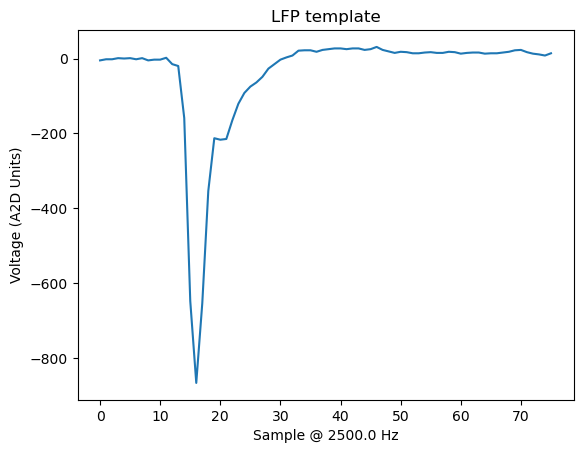

PyObject Text(0.5, 1.0, 'LFP template')

In [9]:
# Get the mean template for the spike-triggered LFP. We get it on the same primary channel
# This is a bit easier since we don't have to worry about optimal alignment
lfp_template = FlocculusClassifier2025.get_template(recording_lfp_band, neuron, channels=[primary_channel], clip_width=(5e-3, 25e-3))
plot(lfp_template)
xlabel("Sample @ $(FlocculusClassifier2025.sampling_rate(recording_lfp_band)) Hz")
ylabel("Voltage (A2D Units)")
title("LFP template")

# Extract rate-based features

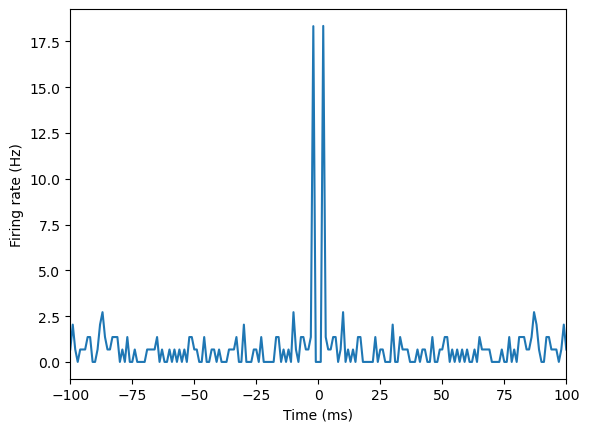

In [10]:
# Plot the auto-correlogram for this neuron
# Note the large peaks very near t=0. These correspond to spikelets of this complex spike
FlocculusClassifier2025.plot_auto_correlogram(neuron)

# Instead of plotting it, let's save it for input to our classifier
time_axis = 1e-3:1e-3:250e-3 
# Note that time axis specifies that this is one-sided ACG (because it is ACGs 
# are symmetric, so we don't need the other size for classification
acg_2d = FlocculusClassifier2025.get_auto_correlogram(neuron, time_axis=time_axis);

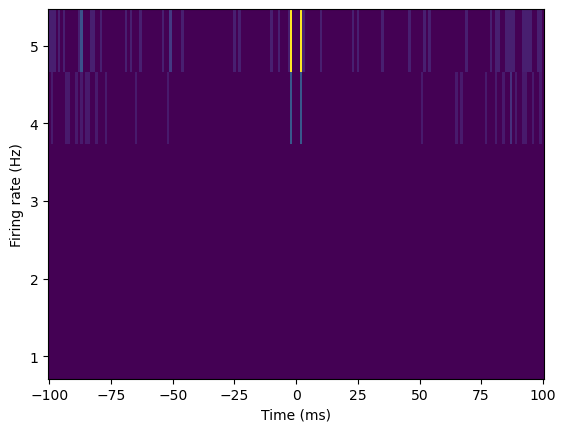

In [11]:
# Plot the 3D auto-correlogram for this neuron (acg as a function of firing rate)
# Note the large peaks very near t=0. These correspond to spikelets of this complex spike
FlocculusClassifier2025.plot_auto_correlogram_vs_firing_rate(neuron)

# Instead of plotting it, let's save it for input to our classifier
time_axis = 1e-3:1e-3:250e-3 
# Note that time axis specifies that this is one-sided ACG (because it is ACGs 
# are symmetric, so we don't need the other size for classification
_, acg_3d = FlocculusClassifier2025.get_auto_correlogram_vs_firing_rate(neuron, time_axis=time_axis);
# We discard the first output of `get_auto_correlogram_vs_firing_rate` which specifies the firing
# rate axis (vertical axis in the output plot). We don't need this axis for classification.

# Preprocess inputs

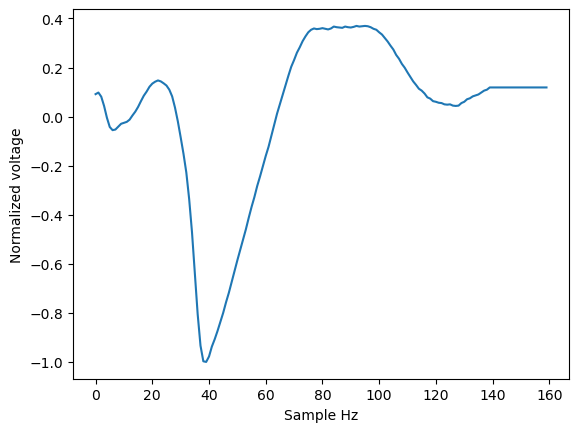

PyObject Text(24.000000000000007, 0.5, 'Normalized voltage')

In [12]:
primary_template = FlocculusClassifier2025.preprocess_template(primary_template, 
    original_sampling_rate=FlocculusClassifier2025.sampling_rate(recording_spike_band), 
    output_sampling_rate=40000.0, peak_sign=:negative, normalize=true, clip_width=(1e-3, 3e-3))
primary_template = Float32.(primary_template); # Explicit conversion to Float32 for input to Flux
@assert length(primary_template) == 160
plot(primary_template)
xlabel("Sample Hz")
ylabel("Normalized voltage")

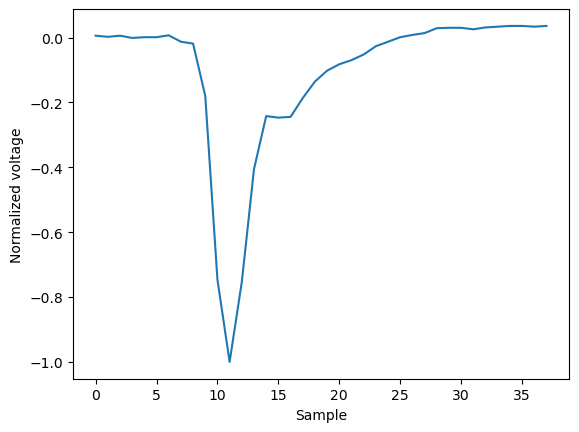

PyObject Text(24.000000000000007, 0.5, 'Normalized voltage')

In [13]:
lfp_template = FlocculusClassifier2025.preprocess_template(lfp_template, 
    original_sampling_rate=FlocculusClassifier2025.sampling_rate(recording_lfp_band), 
    output_sampling_rate=2500, normalize=true, clip_width=(5e-3, 10e-3), peak_sign=:negative, peak_range=(1e-3, 10e-3))
lfp_template = Float32.(lfp_template) # Explicit conversion to Float32 for input to Flux
@assert length(lfp_template) == 38
plot(lfp_template)
xlabel("Sample")
ylabel("Normalized voltage")

In [14]:
# Scale the ACGs appropriately (similar to normalizing a feature space)
# This puts them roughly on the same scale as the normalized waveforms and LFP
acg_2d = Float32.(acg_2d ./ (100 * step(time_axis)))
acg_3d = Float32.(acg_3d ./ (100 * step(time_axis)));

In [15]:
# Note that the order for the MLP input is important 
mlp_input = vcat(primary_template, lfp_template, acg_2d) 
@assert length(mlp_input) == 449
@assert all(size(acg_3d) .== (10, 250))

In [16]:
trained_models, classes = FlocculusClassifier2025.get_trained_models();

In [17]:
predicted_label, confidence_ratio, label_probabilities = FlocculusClassifier2025.predict(trained_models, classes, acg_3d, mlp_input)
display("Neuron is a $predicted_label with a probability of $(label_probabilities[predicted_label])")

"Neuron is a cs with a probability of 0.9949274063110352"